<a href="https://colab.research.google.com/github/lulumulum86/VAE_Variational_Autoencoder/blob/main/VAE_DLL_Tugas3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Tugas 3 (VAE) Matkul Deep Learning Lanjut**
---
# **Nama  : Lu'luah Nafisah Ulum**  
# **NIM     : 41236607**  
# **Kelas : TI-2023-KIP-C1**  
---

In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())


In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE.
# Kita menyertakan konfigurasi loss dummy [None, None, MSE] untuk menangani
# struktur output (z_mean, z_log_var, reconstruction) saat validasi berjalan,
# meskipun training loop utama dikendalikan oleh custom train_step.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])

print("Memulai pelatihan VAE (30 Epoch)...")

# Melatih model dengan 30 epoch sesuai instruksi
history = vae.fit(
    x_train,
    epochs=30,  # Diubah menjadi 30 epoch
    batch_size=128,
    validation_data=(x_test, x_test)
)

print("Pelatihan selesai.")

Memulai pelatihan VAE (30 Epoch)...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - kl_loss: 4.6764 - reconstruction_loss: 387.8424 - total_loss: 392.5187 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 5.9850 - reconstruction_loss: 265.7426 - total_loss: 271.7276 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9657 - reconstruction_loss: 261.5596 - total_loss: 267.5254 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 6.0170 - reconstruction_loss: 259.5482 - total_loss: 265.5652 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0694 - reconstruction

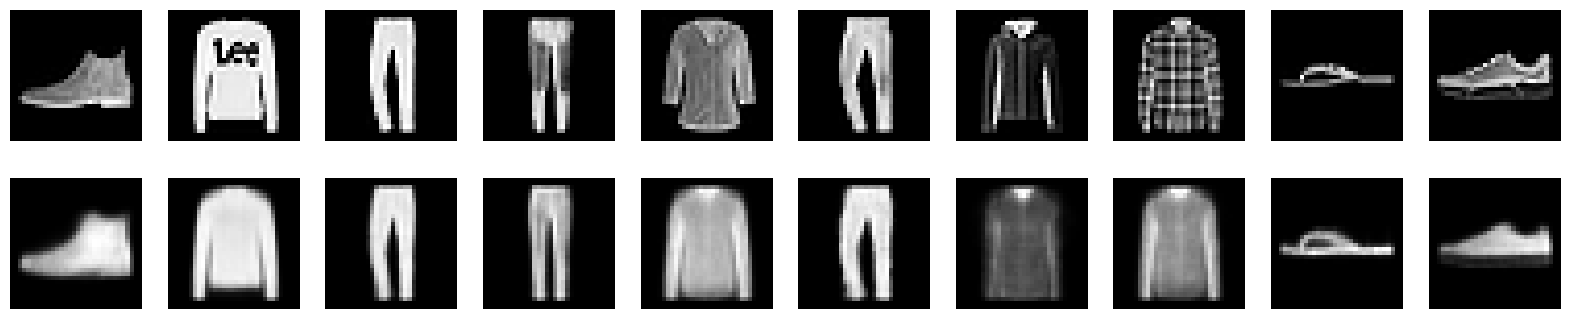

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

Sedang menghitung representasi latent space...
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


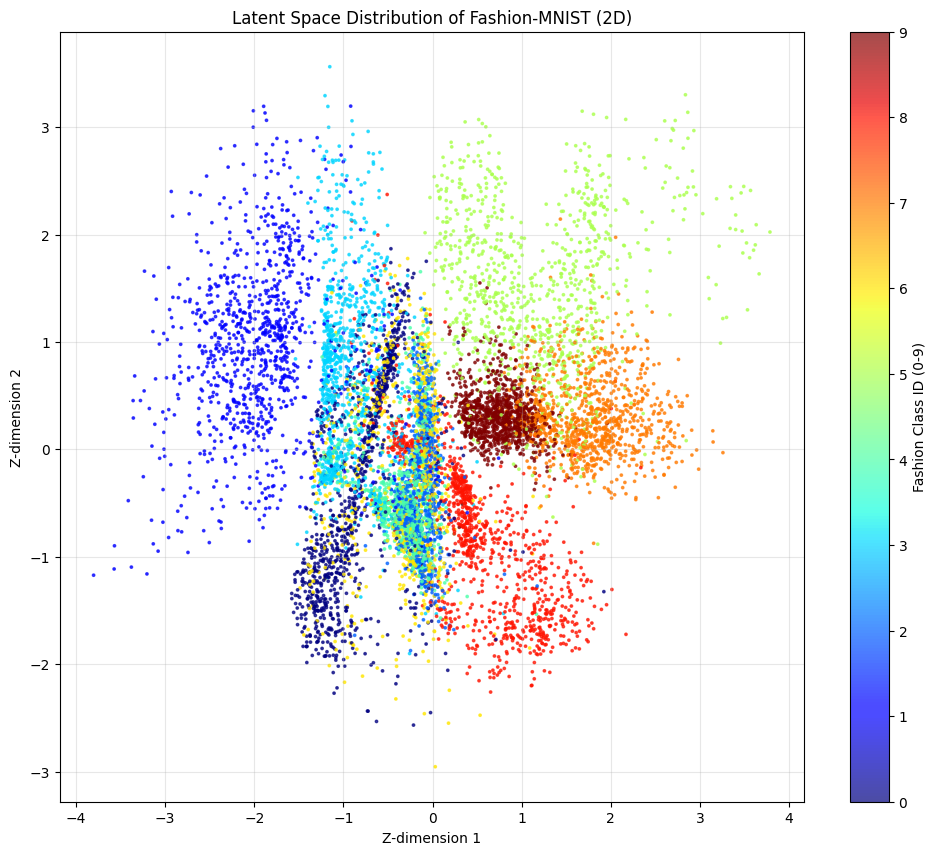

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

(_, _), (_, y_test) = keras.datasets.fashion_mnist.load_data()

# ---------------------------------------------------------
# 1. Hitung Latent Vector (z_mean)
# ---------------------------------------------------------
# Kita menggunakan encoder untuk memprediksi posisi latent dari data test.
# Encoder mengembalikan [z_mean, z_log_var, z].
# Untuk visualisasi distribusi, yang paling akurat adalah 'z_mean'.
print("Sedang menghitung representasi latent space...")
z_mean, _, _ = vae.encoder.predict(x_test, batch_size=128)

# ---------------------------------------------------------
# 2. Plotting
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))

# c=y_test akan memberi warna berbeda untuk setiap kelas (baju, sepatu, tas, dll)
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="jet", alpha=0.7, s=3)

plt.colorbar(scatter, label="Fashion Class ID (0-9)")
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST (2D)")
plt.grid(True, alpha=0.3)

# Menambahkan legend manual agar lebih jelas (Opsional)
# 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat,
# 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

# Tampilkan plot
plt.show()

In [9]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


# **Generate Latent Space Means for Test Data**

In [11]:
print("Shape of z_mean:", z_mean.shape)
print("First 5 elements of z_mean:\n", z_mean[:5])

Shape of z_mean: (10000, 2)
First 5 elements of z_mean:
 [[ 1.1156251   0.5157088 ]
 [-0.18653116 -0.7841542 ]
 [-3.0146682   0.15841338]
 [-1.705696    1.2135667 ]
 [-0.02091858 -0.30295235]]


# **Visualize Latent Space Distribution by Class**

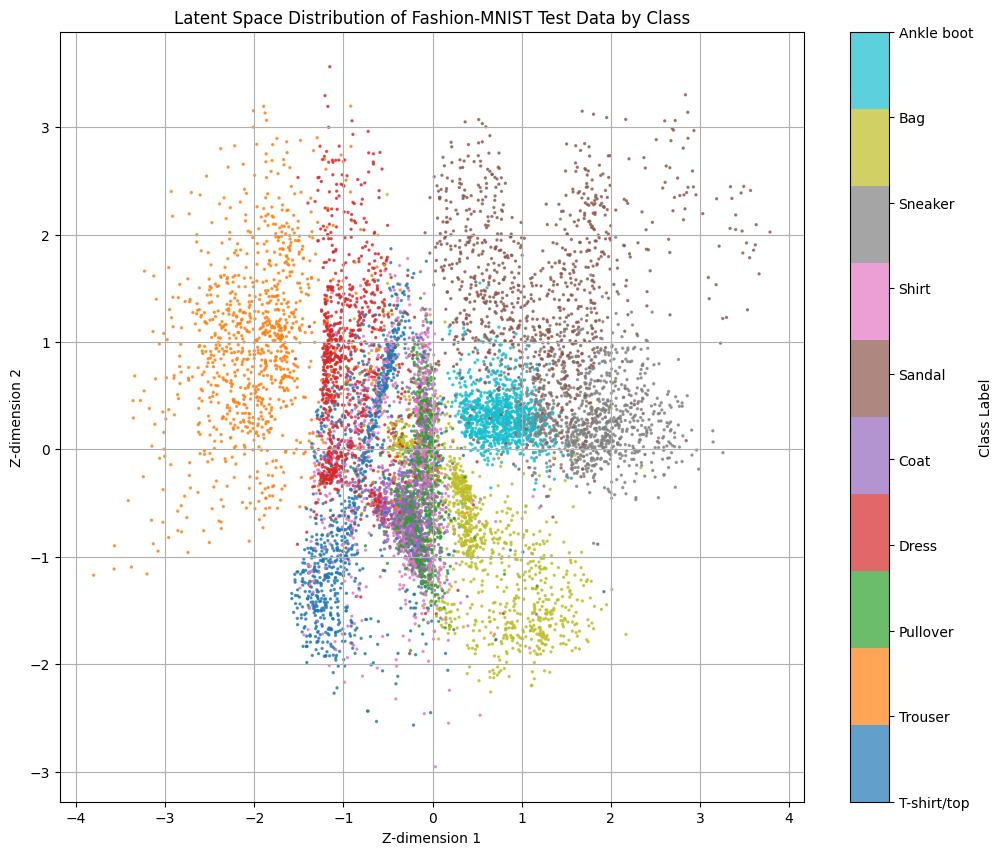

In [13]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

# **Latent Space Arithmetic (Interpolasi)**

Menampilkan interpolasi linear...


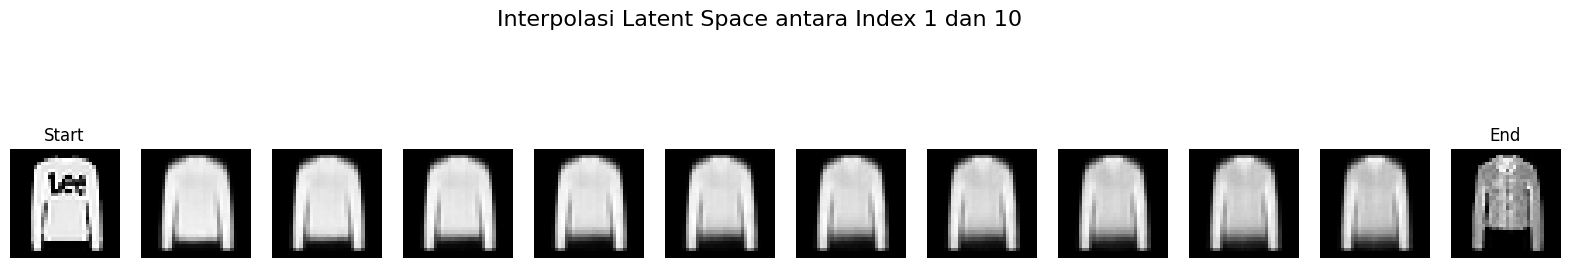

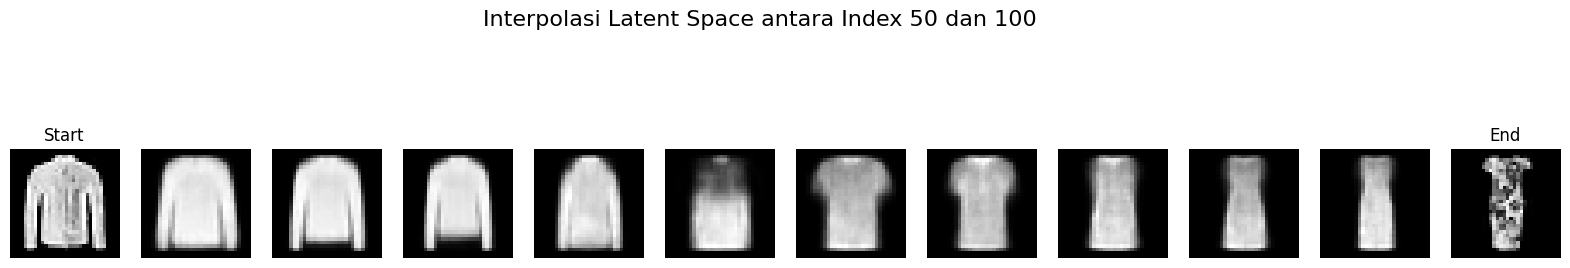

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_interpolation(model, data, index1, index2, steps=10):
    # 1. Ambil dua gambar dari data test
    img1 = data[index1]
    img2 = data[index2]

    # 2. Encode kedua gambar ke latent space (ambil z_mean)
    # expand_dims karena encoder butuh batch dimension
    z1, _, _ = model.encoder.predict(np.expand_dims(img1, 0), verbose=0)
    z2, _, _ = model.encoder.predict(np.expand_dims(img2, 0), verbose=0)

    # Hilangkan dimensi batch -> shape (2,)
    z1 = z1[0]
    z2 = z2[0]

    # 3. Buat vektor interpolasi (linear interpolation / lerp)
    # alpha berjalan dari 0 sampai 1
    alphas = np.linspace(0, 1, steps)
    interpolated_z = []
    for alpha in alphas:
        # Rumus: z_new = (1 - alpha) * z1 + alpha * z2
        z_interp = (1 - alpha) * z1 + alpha * z2
        interpolated_z.append(z_interp)

    interpolated_z = np.array(interpolated_z)

    # 4. Decode vektor interpolasi kembali menjadi gambar
    decoded_imgs = model.decoder.predict(interpolated_z, verbose=0)

    # 5. Visualisasi
    plt.figure(figsize=(20, 4))

    # Tampilkan Gambar Awal
    ax = plt.subplot(1, steps + 2, 1)
    plt.imshow(img1.squeeze(), cmap="gray")
    plt.title("Start")
    plt.axis("off")

    # Tampilkan Interpolasi
    for i in range(steps):
        ax = plt.subplot(1, steps + 2, i + 2)
        plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
        plt.axis("off")

    # Tampilkan Gambar Akhir
    ax = plt.subplot(1, steps + 2, steps + 2)
    plt.imshow(img2.squeeze(), cmap="gray")
    plt.title("End")
    plt.axis("off")

    plt.suptitle(f"Interpolasi Latent Space antara Index {index1} dan {index2}", fontsize=16)
    plt.show()

# --- EKSEKUSI TUGAS 3 ---
# Pilih dua index acak atau spesifik yang berbeda kelas untuk melihat morphing
# Contoh: Index 1 (mungkin sepatu) ke Index 10 (mungkin baju)
print("Menampilkan interpolasi linear...")
plot_latent_interpolation(vae, x_test, index1=1, index2=10, steps=10)

# Coba pasangan lain
plot_latent_interpolation(vae, x_test, index1=50, index2=100, steps=10)

# **Perbandingan VAE vs Autoencoder (AE) Biasa**

Membangun dan Melatih Autoencoder (AE) Standar untuk perbandingan...
Training Autoencoder (30 Epoch)...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0668 - val_loss: 0.0252
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0251 - val_loss: 0.0236
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0217 - val_loss: 0.0215
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0214 - val_loss: 0.0215
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0209 - val_loss: 0.0211
Epoch 11/30
469/469 ━━━━

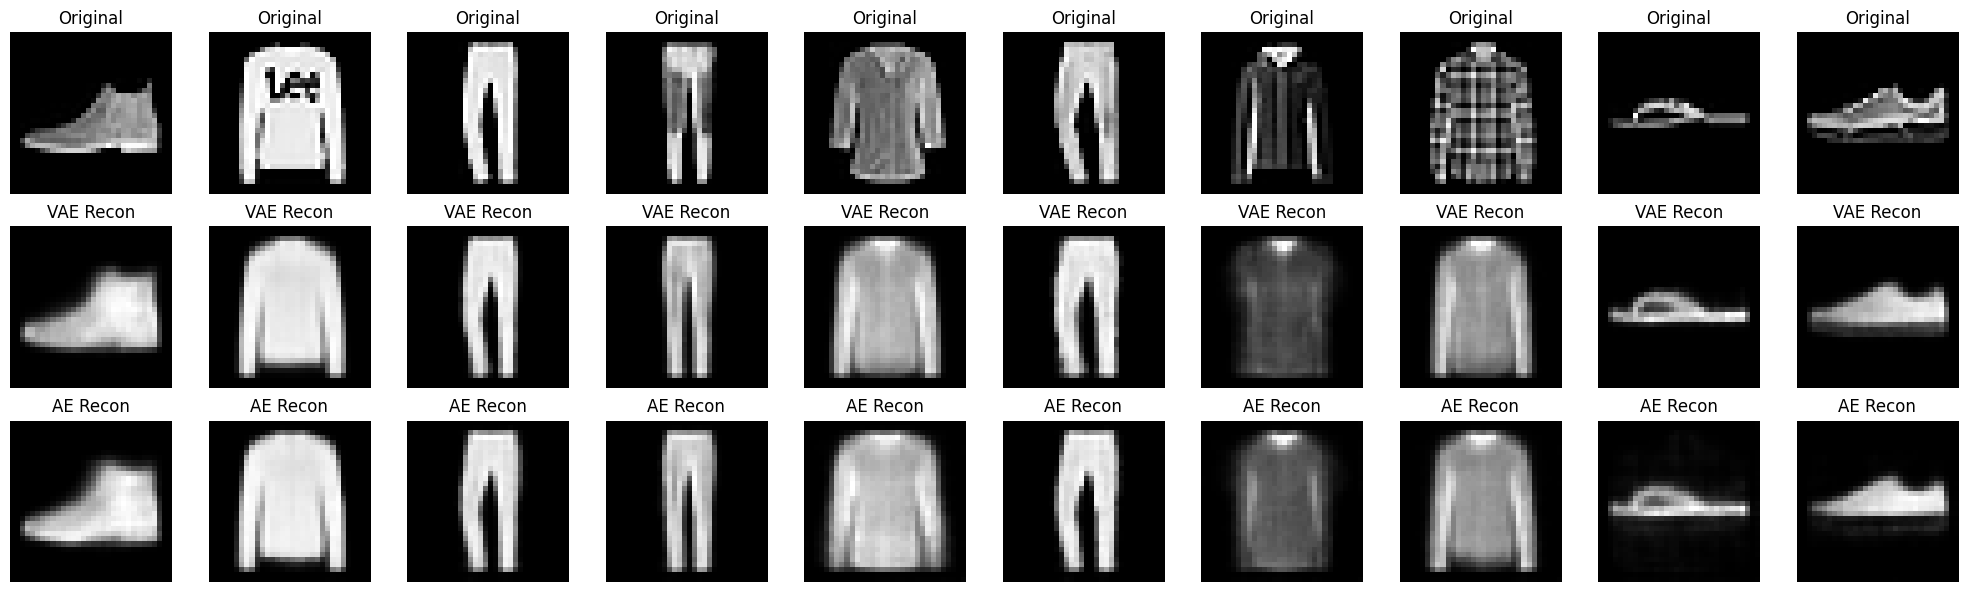

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

print("Membangun dan Melatih Autoencoder (AE) Standar untuk perbandingan...")

# --- 1. Bangun Autoencoder Standar (Arsitektur mirip VAE tapi tanpa Sampling/KL) ---

# Encoder AE
ae_encoder_input = layers.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ae_encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
# Bedanya disini: AE langsung ke latent vector, tidak ada mean/log_var/sampling
ae_latent = layers.Dense(latent_dim, name="ae_latent")(x)
ae_encoder = models.Model(ae_encoder_input, ae_latent, name="ae_encoder")

# Decoder AE (Sama persis dengan VAE decoder agar fair)
ae_decoder_input = layers.Input(shape=(latent_dim,))
# Gunakan shape_before_flattening dari script VAE sebelumnya
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(ae_decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
ae_decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
ae_decoder = models.Model(ae_decoder_input, ae_decoder_output, name="ae_decoder")

# Gabungkan menjadi AE
ae = models.Model(ae_encoder_input, ae_decoder(ae_encoder(ae_encoder_input)))
ae.compile(optimizer='adam', loss='mse') # AE biasa menggunakan MSE

# --- 2. Latih AE ---
# epoch 30 agar adil (apple-to-apple) dengan VAE
print("Training Autoencoder (30 Epoch)...")
ae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test), verbose=1)


# --- 3. Visualisasi Perbandingan (Original vs VAE vs AE) ---
def compare_reconstructions(vae_model, ae_model, data, n=10):
    # Ambil sampel data
    sample_data = data[:n]

    # Prediksi VAE (ingat output VAE ada 3: mean, logvar, recon)
    _, _, vae_recon = vae_model(sample_data)

    # Prediksi AE
    ae_recon = ae_model.predict(sample_data, verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Baris 1: Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(sample_data[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Baris 2: VAE Reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_recon[i].numpy().squeeze(), cmap="gray")
        plt.title("VAE Recon")
        plt.axis("off")

        # Baris 3: AE Reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_recon[i].squeeze(), cmap="gray")
        plt.title("AE Recon")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Menampilkan perbandingan hasil rekonstruksi...")
compare_reconstructions(vae, ae, x_test)
